In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('preprocessedTrain.csv') #import data
X = data.loc[:, data.columns != 'AdoptionSpeed'] #create X without labels
X = X.drop('Description',axis=1) #drop non numerical values
X = X.drop('PetID',axis=1) #
X = X.drop('RescuerID',axis=1)

y = data['AdoptionSpeed'] #label vector

attributeNames = list(X.columns.values) #for printing purposes
classNames = ['sameDay','firstWeek','firstMonth','2nd3rdMonth','notAdopted']

In [4]:
from sklearn import tree
from Toolbox import treeprint
from sklearn import model_selection
import matplotlib.pyplot as plt

test_proportion = 0.5  # set crossval proportion
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=test_proportion)
levels = range(2,51)
error = np.zeros((2,len(levels)))

for t in levels:
    dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=t) #train decision tree
    dtc = dtc.fit(X_train,y_train)
    
    y_est_test = dtc.predict(X_test)
    y_est_train = dtc.predict(X_train)
    
    test_class_error = 1-np.mean(y_est_test == y_test)
    train_class_error = 1-np.mean(y_est_train == y_train)
    error[0,t-2], error[1,t-2]= train_class_error, test_class_error


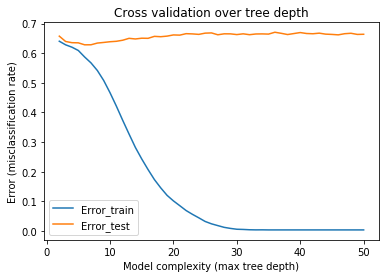

Lowest error is 0.33 at 44


In [5]:
plt.plot(levels, error[0,:])
plt.plot(levels, error[1,:])
plt.xlabel('Model complexity (max tree depth)')
plt.ylabel('Error (misclassification rate)')
plt.legend(['Error_train','Error_test']) 
plt.title('Cross validation over tree depth')
plt.show()  
errorSum = sum(error)
print('Lowest error is {:.2f} at {}'.format(min(errorSum)/2, np.argmin(errorSum)))


In [8]:
dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth = 7)
dtc = dtc.fit(X,y)


treeprint.tree_print(dtc, attributeNames, classNames) #plot smol tree

               |->5  firstWeek
               |
            |->4 then if Name =< 0.50: go to 5, else go to 6
            |  |
            |  |     |->8  2nd3rdMonth
            |  |     |
            |  |  |->7 then if Color1 =< 1.50: go to 8, else go to 9
            |  |  |  |
            |  |  |  |->9  notAdopted
            |  |  |
            |  |->6 else if love =< 0.50: go to 7, else go to 10
            |     |
            |     |  |->11  2nd3rdMonth
            |     |  |
            |     |->10 else if play =< 0.50: go to 11, else go to 12
            |        |
            |        |->12  firstWeek
            |
         |->3 then if Type =< 1.50: go to 4, else go to 13
         |  |
         |  |     |->15  firstMonth
         |  |     |
         |  |  |->14 then if Age =< 0.50: go to 15, else go to 16
         |  |  |  |
         |  |  |  |  |->17  notAdopted
         |  |  |  |  |
         |  |  |  |->16 else if MaturitySize =< 2.50: go to 17, else go to 18
         |  | 

Based on the small decision tree, the most important factors in order are: Age, breed, photo. Other relevant factors are Vaccinated, certain key words in the description.